## Anomaly Detection Using Random Cut Forest VS Isolation Forest

In this section, we use the Random Cut Forest (RCF) algorithm for unsupervised anomaly detection on the daily new COVID-19 cases time series.

**Approach:**
- The RCF algorithm assigns an "anomaly score" to each data point based on how isolated it is within the data distribution.
- Higher scores indicate points that are more likely to be anomalies or outliers.
- We fit the RCF model to our time series and flag the points with the highest anomaly scores for further inspection.
- This helps identify unusual spikes or drops in the daily case numbers that may warrant deeper investigation.



## Forecasting with Random Forest Regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load your pre-processed data (from previous steps)
df = pd.read_csv('global_covid_new_cases.csv', parse_dates=['date'])
# We will use Isolation Forest (sklearn), which is similar in principle to Random Cut Forest for anomaly detection
# (You can use Amazon SageMaker's Random Cut Forest for large-scale or AWS-native projects)


# Create lag features (using the previous 7 days as predictors)
for lag in range(1, 8):
    df[f'lag_{lag}'] = df['smoothed_new_cases'].shift(lag)

# Remove rows with missing lag values
df = df.dropna().reset_index(drop=True)



In [ ]:
# Train/Test Split (last 30 days for test) 
train = df.iloc[:-30]
test = df.iloc[-30:]

feature_cols = [f'lag_{lag}' for lag in range(1, 8)]
X_train, y_train = train[feature_cols], train['smoothed_new_cases']
X_test, y_test = test[feature_cols], test['smoothed_new_cases']

In [ ]:
# Fit the Random Forest Regressor 
rf = RandomForestRegressor(n_estimators=100, random_state=45)
rf.fit(X_train, y_train)

# Forecast on the test set 
preds = rf.predict(X_test)

In [ ]:
# Evaluation
rmse = mean_squared_error(y_test, preds, squared=False)
print(f"Random Forest RMSE on Test Set: {rmse:.2f}")

Random Forest RMSE on Test Set: 8628.86


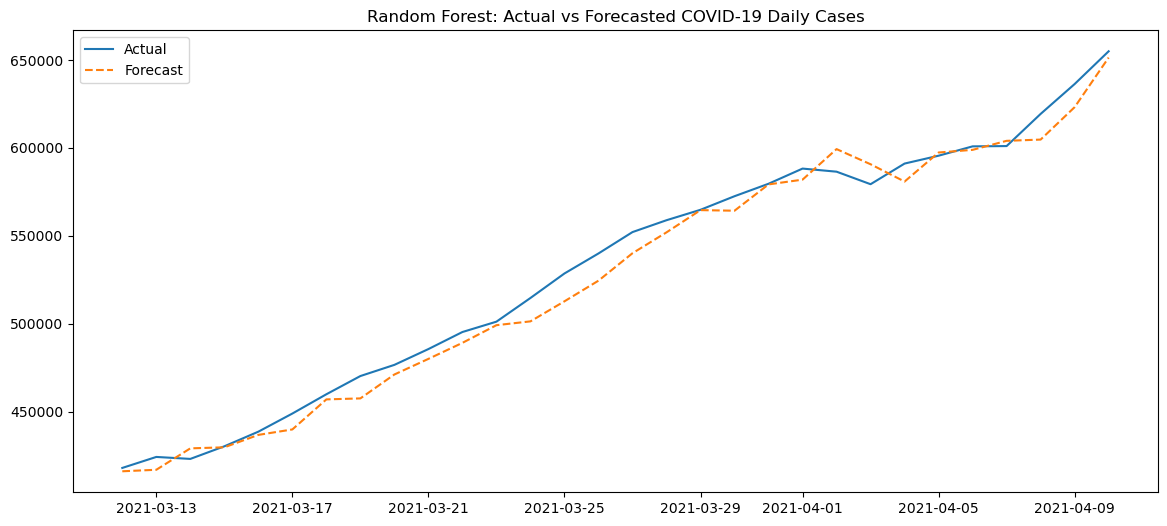

In [ ]:
# Plot
plt.figure(figsize=(14,6))
plt.plot(test['date'], y_test, label='Actual')
plt.plot(test['date'], preds, label='Forecast', linestyle='dashed')
plt.title('Random Forest: Actual vs Forecasted COVID-19 Daily Cases')
plt.legend()
plt.show()


### Forcasting using Isolation Forest


In [6]:

# Isolation Forest (sklearn) is similar in principle to Random Cut Forest for anomaly detection
# (You can use Amazon SageMaker's Random Cut Forest for large-scale or AWS-native projects)

# Prepare the data: reshape values for the model
values = df['smoothed_new_cases'].values.reshape(-1, 1)


In [8]:
from sklearn.ensemble import IsolationForest
# Initialize the Isolation Forest model for anomaly detection
# (n_estimators and contamination can be tuned based on your needs)
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
model.fit(values)

IsolationForest(contamination=0.01, random_state=42)

In [9]:
# Get anomaly scores (the lower, the more anomalous)
df['anomaly_score'] = model.decision_function(values)

In [10]:
# Predict anomalies: -1 = anomaly, 1 = normal
df['anomaly'] = model.predict(values) == -1

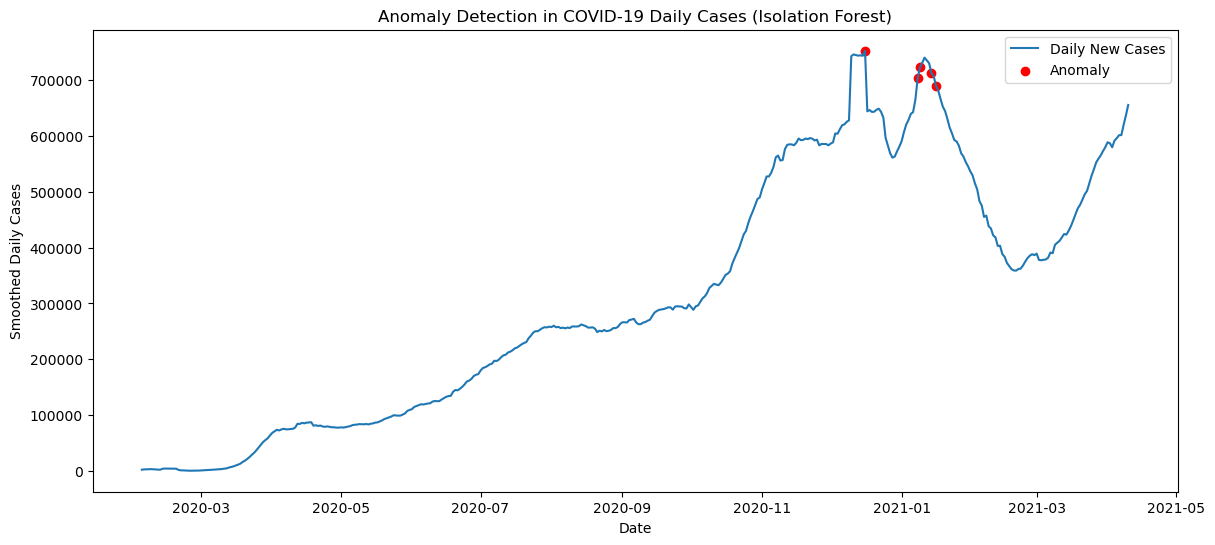

In [11]:
# Plot results: anomalies are shown as red dots
plt.figure(figsize=(14,6))
plt.plot(df['date'], df['smoothed_new_cases'], label='Daily New Cases')
plt.scatter(df[df['anomaly']]['date'], df[df['anomaly']]['smoothed_new_cases'],
            color='red', label='Anomaly')
plt.title('Anomaly Detection in COVID-19 Daily Cases (Isolation Forest)')
plt.xlabel('Date')
plt.ylabel('Smoothed Daily Cases')
plt.legend()
plt.show()

### Why Random Cut Forest (or Isolation Forest)?

Random Cut Forest is a robust algorithm for detecting anomalies in time series or multidimensional data.  
Isolation Forest, available in Scikit-learn, offers similar principles for Python projects outside AWS.  
Both work by isolating outliers that are different from the general data distribution, making them well-suited for detecting rare events in healthcare or sensor data.
